In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


# Learning choice functions

We apply our first-aggregate-then-evaluate (FATE) architecture to the problem of learning choice functions.
We will first start to investigate latent linear functions to sanity check our implementation.
Then we will move to the problem of learning Pareto-optimality.



## Learning a latent linear function

In [2]:
data_seed = 126
weight_seed = 35
n_train = 100000
n_test = 100000
n_features = 2
n_objects = 6
n_rep_units = 5
threshold = 1

In [3]:
from sklearn.utils import check_random_state
def make_latent_linear_choices(n_inst=10000, n_features=2, n_objects=6,
                               n_rep_units=5, threshold=0.,
                               data_seed=None, weight_seed=None):
    rand = check_random_state(data_seed)
    ranw = check_random_state(weight_seed)
    X = rand.uniform(-1, 1, size=(n_inst, n_objects, n_features))
    W_rep = ranw.randn(n_features, n_rep_units)
    rep = X.dot(W_rep).mean(axis=-2)
    w_join = ranw.randn(n_features + n_rep_units)
    joint_matrix = np.empty((n_objects, n_inst, n_features + n_rep_units),
                            dtype=np.float32)
    for i in range(n_objects):
        joint_matrix[i] = np.concatenate((X[:, i], rep), axis=-1)
    scores = joint_matrix.dot(w_join)
    Y = scores > threshold
    return X, Y.T, W_rep, w_join

In [4]:
X_train, Y_train, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed,
    weight_seed=weight_seed,
    threshold=threshold)
X_test, Y_test, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed+1,
    weight_seed=weight_seed,
    threshold=threshold)
print(Y_train.mean())

0.160225


Since we used only 2 features, we can plot the positive and negative objects of the dataset:

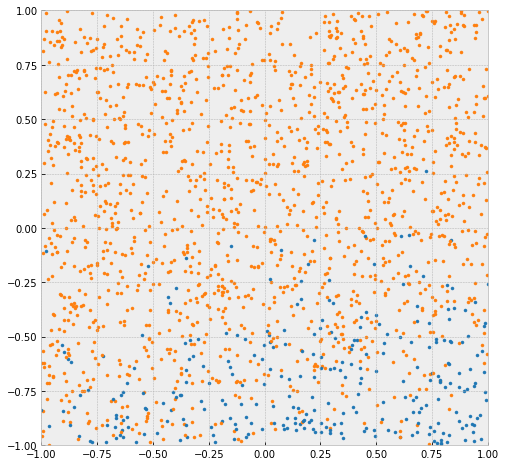

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:300], Y_train[:300])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.')
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.')

In [4]:
from yellowfin import YFOptimizer
from keras.optimizers import TFOptimizer
from keras.metrics import binary_accuracy
opt = TFOptimizer(YFOptimizer(learning_rate=0.1))
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=2,
                          n_hidden_joint_units=32,
                          n_hidden_set_layers=2,
                          n_hidden_set_units=32,
                          optimizer=opt,
                          batch_size=512,
                          metrics=[binary_accuracy])

In [7]:
fate.fit(X_train, Y_train, verbose=True, epochs=50)

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
81000/81000 [==============================] - 5s 56us/step - loss: 0.0942 - binary_accuracy: 0.9644 - val_loss: 0.0499 - val_binary_accuracy: 0.9767
Epoch 2/50
81000/81000 [==============================] - 3s 41us/step - loss: 0.0429 - binary_accuracy: 0.9824 - val_loss: 0.0438 - val_binary_accuracy: 0.9800
Epoch 3/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0301 - binary_accuracy: 0.9870 - val_loss: 0.0603 - val_binary_accuracy: 0.9758
Epoch 4/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0352 - binary_accuracy: 0.9851 - val_loss: 0.0201 - val_binary_accuracy: 0.9913
Epoch 5/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0293 - binary_accuracy: 0.9880 - val_loss: 0.0107 - val_binary_accuracy: 0.9970
Epoch 6/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0278 - binary_accuracy: 0.9889 - val_loss: 0.0225 - val_binary_ac

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [8]:
fate.threshold

0.39622626

In [9]:
pred = fate.predict(X_test)

In [10]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.9921
Micro F1 measure: 0.9921
Subset Accuracy: 0.9853


In [11]:
pred_threshold = fate.predict_scores(X_test) > fate.threshold

In [12]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred_threshold)))

Macro F1 measure: 0.9944
Micro F1 measure: 0.9944
Subset Accuracy: 0.9896


## Learning Pareto-Optimality
We now try to solve the problem of predicting the Pareto-optimal set of points $O\subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

In [13]:
from sklearn.utils import check_random_state
def pareto_front(X, signs=None):
    n_points, n_attributes = X.shape
    if signs is None:
        signs = -np.ones(n_attributes)
    pareto = np.ones(n_points, dtype=bool)
    for i, attr in enumerate(X):
        pareto[i] = np.all(np.any((X*signs[None, :]) <= (attr*signs), axis=1))
    return pareto

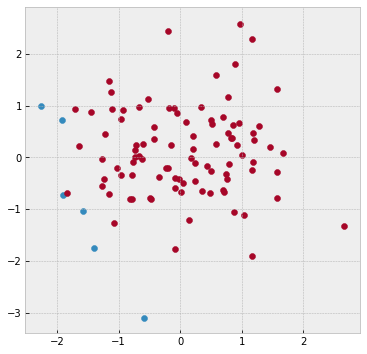

In [14]:
X = np.random.randn(100, 2)
fig, ax = plt.subplots(figsize=(6,6))
pareto = pareto_front(X)
ax.scatter(X[pareto][:, 0], X[pareto][:, 1])
ax.scatter(X[~pareto][:, 0], X[~pareto][:, 1]);

In this example we have to criteria which we want to minimize.
The blue points form the Pareto-front.

In [15]:
from sklearn.utils import check_random_state
def sample_unit_ball(n_inst=10000, n_features=2, rng=None, radius=1.):
    rng = check_random_state(rng)
    X = rng.randn(n_inst, n_features)
    u = rng.uniform(size=n_inst)[:, None]
    X /= np.linalg.norm(X, axis=1, ord=2)[:, None]
    X *= radius * u
    return X
def make_randn_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None, center=0.):
    """Generate random objects from a d-dimensional isometric normal distribution.
    
    This should be the easiest possible Pareto-problem, since the model can learn
    a latent-utility which scores how likely a point is on the front (independent
    of the other points)."""
    rand = check_random_state(data_seed)
    X = rand.randn(n_inst, n_objects, n_features)
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(n_inst):
        Y[i] = pareto_front(X[i])
    return X+center, Y
def make_globular_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None,
                                 cluster_spread=1., cluster_size=10):
    rand = check_random_state(data_seed)
    X = np.empty((n_inst, n_objects, n_features))
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(int(n_inst / cluster_size)):
        center = sample_unit_ball(n_inst=1, n_features=n_features,
                                  rng=rand, radius=cluster_spread)
        x, y = make_randn_pareto_choices(n_inst=cluster_size, n_features=n_features, n_objects=n_objects,
                                         data_seed=rand, center=center)
        X[i*cluster_size:(i+1)*cluster_size] = x
        Y[i*cluster_size:(i+1)*cluster_size] = y
    return X, Y

In [5]:
from csrank import SyntheticIterator
n_inst = 1024
n_objects = 30
n_features = 5
pareto_iter = SyntheticIterator(make_randn_pareto_choices,
                                n_inst=n_inst, n_features=n_features, n_objects=n_objects)

In [16]:
n_train = 10000
n_test = 100000
n_objects = 30
n_features = 2
seed = 123

X_train, Y_train = make_globular_pareto_choices(n_inst=n_train, n_objects=n_objects,
                                             n_features=n_features, data_seed=seed,
                                                cluster_spread=10)
X_test, Y_test = make_globular_pareto_choices(n_inst=n_test, n_objects=n_objects,
                                           n_features=n_features, data_seed=seed+1,
                                              cluster_spread=10)

Text(0.5,1,'Learning the Pareto-front of a given set of points')

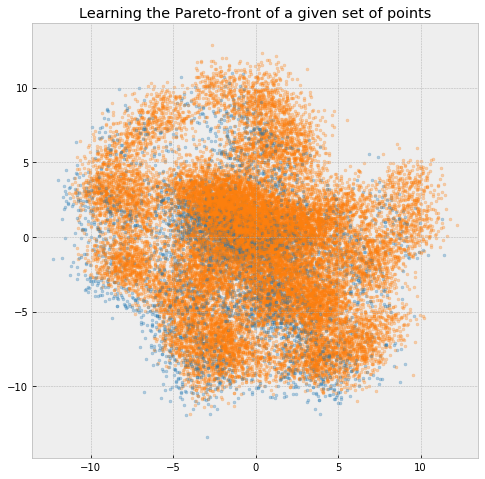

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:1000], Y_train[:1000])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.', alpha=0.3)
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.', alpha=0.3)
plt.title("Learning the Pareto-front of a given set of points")
#plt.savefig('globular.png')

(-1.5, 1.5)

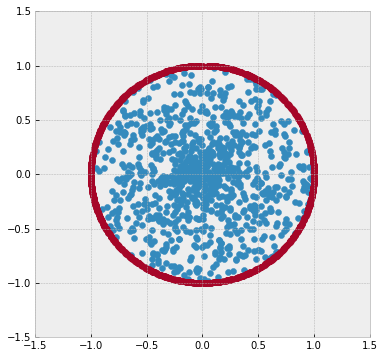

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
n = 1000
a = np.random.randn(n, 2)
u = np.random.uniform(size=n)[:, None]
b = a / np.linalg.norm(a, ord=2, axis=1)[:, None]
c = b * u
#ax.scatter(a[:, 0], a[:, 1])
ax.scatter(c[:, 0], c[:, 1])
ax.scatter(b[:, 0], b[:, 1])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [17]:
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return -f1_score(y_true, y_pred, average='samples')

In [10]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          kernel_regularizer=l2(1e-6))

In [11]:
from csrank import ParameterOptimizer
ranges = {fate: {'n_hidden_set_units': (8, 128),
                 'n_hidden_set_layers': (1, 10),
                 'n_hidden_joint_units': (8,  128),
                 'n_hidden_joint_layers': (1, 10),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-6, 1e-1, 'log-uniform'),
                 'batch_size': (32, 2048)}}
opt=ParameterOptimizer(fate, optimizer_path='runs/id2', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=100),
                   random_state=None,
                   validation_loss=fmeasure)

In [12]:
import datetime, time
max_time = datetime.timedelta(hours=24)
max_time = max_time.total_seconds() * 1000 * 1000

In [13]:
import logging
# create logger with 'spam_application'
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('opt.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_iter = 50
eta = np.sqrt(8 * np.log(3)/n_iter)
opt.fit(X_train, Y_train, acq_func="gp_hedge", n_iter=n_iter,
        total_duration=max_time, cv_iter=ShuffleSplit(n_splits=1, test_size=0.1),
        acq_func_kwargs=dict(eta=eta))

In [4]:
from skopt.utils import load
opti = load('./~/optdir')

In [7]:
from skopt.utils import create_result
import numpy as np
#opti = opt.optimizer
result = create_result(opti.Xi, opti.yi, opti.space, opti.rng,
                       models=opti.models)

In [8]:
from skopt.utils import expected_minimum
expected_minimum(result)

([0.031342416687816683, 6.0, 77.0, 67.0, 1.7986618554182078e-09, 410.0, 7.0],
 -0.57176405191421509)

In [18]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 77
n_hidden_set_layers = 6
n_hidden_joint_units = 67
n_hidden_joint_layers = 7
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=0.031342416687816683, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=410,
                          kernel_regularizer=l2(1.7986618554182078e-09))Pare

In [19]:
fate.fit(X_train, Y_train, epochs=1000, verbose=True)

Train on 8100 samples, validate on 900 samples
Epoch 1/1000
8100/8100 [==============================] - 7s 876us/step - loss: 0.4196 - val_loss: 0.3227
Epoch 2/1000
8100/8100 [==============================] - 2s 268us/step - loss: 0.3122 - val_loss: 0.2440
Epoch 3/1000
8100/8100 [==============================] - 2s 272us/step - loss: 0.3458 - val_loss: 0.3258
Epoch 4/1000
8100/8100 [==============================] - 2s 273us/step - loss: 0.3741 - val_loss: 0.3263
Epoch 5/1000
8100/8100 [==============================] - 2s 273us/step - loss: 0.3677 - val_loss: 0.3307
Epoch 6/1000
8100/8100 [==============================] - 2s 274us/step - loss: 0.2900 - val_loss: 0.2741
Epoch 7/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2694 - val_loss: 0.2476
Epoch 8/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2442 - val_loss: 0.2137
Epoch 9/1000
8100/8100 [==============================] - 2s 278us/step - loss: 0.2338 - val_loss: 0.2108

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [21]:
fate.threshold

0.27559626

In [20]:
pred = fate.predict(X_test)

In [30]:
pred_scores = fate.predict_scores(X_test)

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
auc = roc_auc_score(Y_test, pred_scores, average='samples')
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


F1: 0.7038613825068271
Precision: 0.5883390156167355
Subset 0/1 Loss: 0.92271
Hamming loss: 0.084829


In [44]:
average_precision_score(Y_test, pred_scores, average='samples')

0.91310872738555571

In [35]:
from sklearn.metrics import precision_score, roc_auc_score, recall_score
recall_score(Y_test, pred, average='samples')

0.83650843073593062

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, pred)

0.077289999999999998

In [43]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(Y_test, pred_scores)

0.9131087273854791

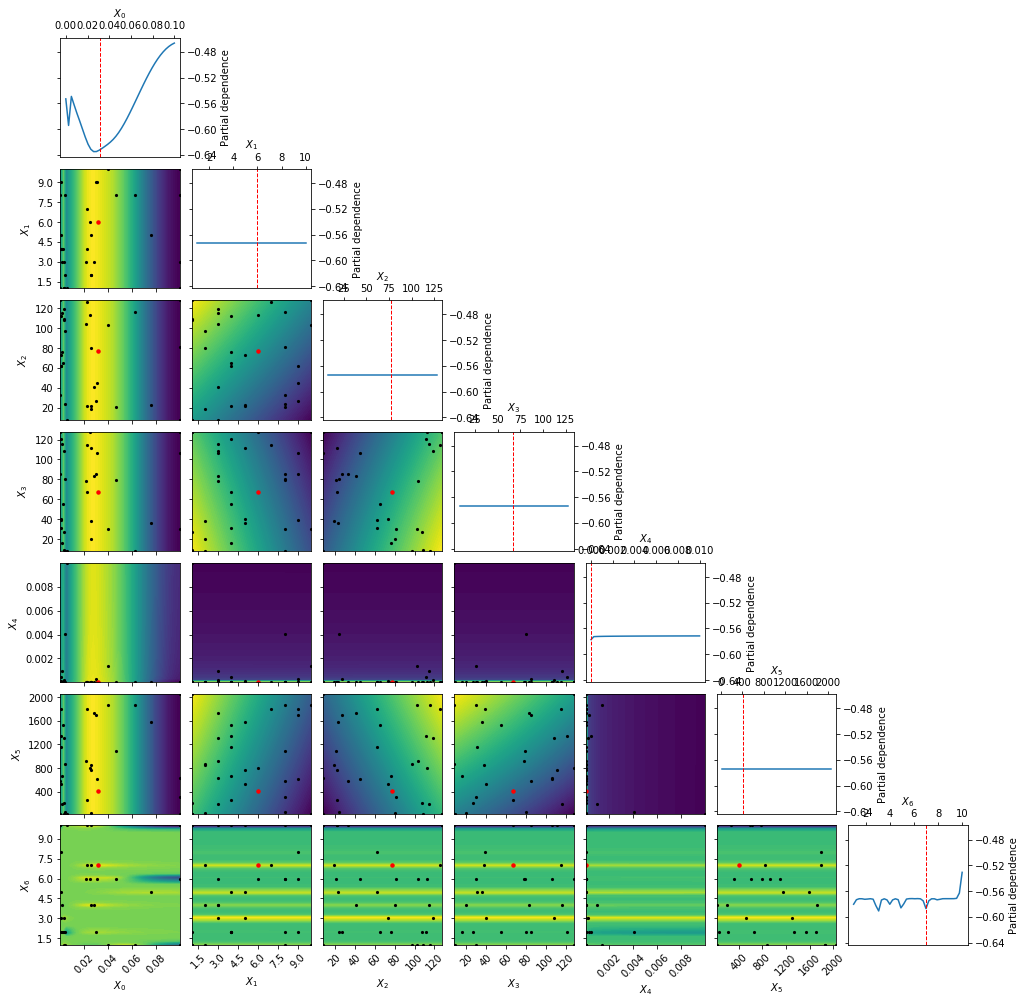

In [10]:
%matplotlib inline
from skopt.plots import plot_objective
plot_objective(result, levels=101);

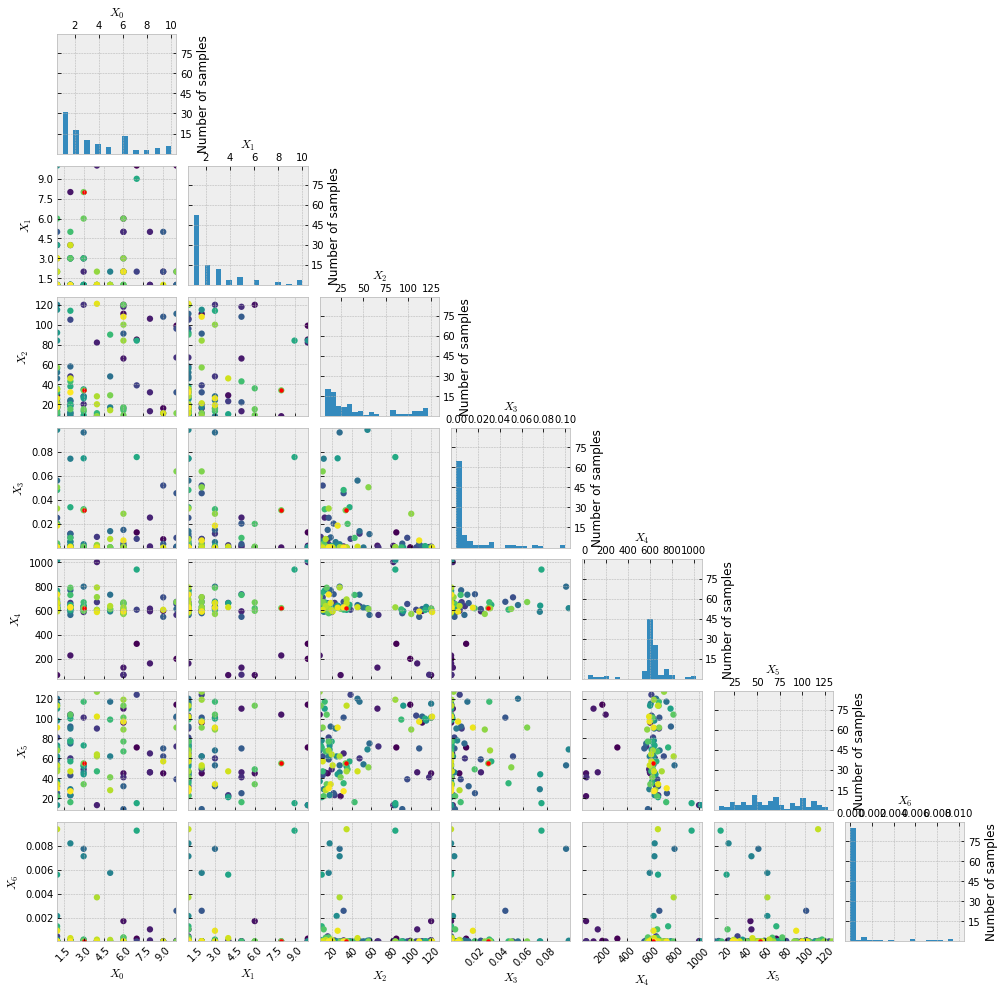

In [19]:
from skopt.plots import plot_evaluations
plot_evaluations(result);

In [60]:
from keras.callbacks import TensorBoard, LearningRateScheduler
netname = '{}-{}-{}-{}-{}d-{}o'.format(n_hidden_set_units, n_hidden_set_layers,
                               n_hidden_joint_units, n_hidden_joint_layers, n_features,
                               n_objects)
tb = TensorBoard(log_dir='/home/kiudee/git/cs-ranking/logs/{}'.format(netname))
tb.__name__ = 'TensorBoard'

def trapezoidal(epoch):
    low_lr = 1e-10
    high_lr = 1e-1
    epochs_ramp_up = 15
    epochs_explore = 60
    epochs_ramp_down = 50
    if epoch <= epochs_ramp_up:
        p = epoch / epochs_ramp_up
        return p * high_lr + (1-p) * low_lr
    elif epoch > epochs_ramp_up and epoch < epochs_explore + epochs_ramp_up:
        return high_lr
    else:
        p = (epoch - epochs_explore - epochs_ramp_up) / epochs_ramp_down
        return min(p * low_lr + (1-p) * high_lr, high_lr)
lr = LearningRateScheduler(trapezoidal)
lr.__name__ = 'LRScheduler'

In [61]:
fate.fit(X_train, Y_train, verbose=False, epochs=140, log_callbacks=[tb, lr])

In [44]:
fate.fit(X_train, Y_train, verbose=False, epochs=10, log_callbacks=[tb],
         optimizer=SGD(lr=1e-6, momentum=0.9, nesterov=True))

In [28]:
X_test, Y_test = make_randn_pareto_choices(n_inst=10000, n_objects=n_objects,
                                           n_features=n_features)

In [127]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.5703
Micro F1 measure: 0.5705
Subset Accuracy: 0.0938


In [43]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.0000
Micro F1 measure: 0.0000
Subset Accuracy: 0.0000


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Learning Largest MNIST Numbers

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return -f1_score(y_true, y_pred, average='samples')

Using TensorFlow backend.


In [2]:
X_train = np.load('./largest_mnist_X_train.npy')
X_test = np.load('./largest_mnist_X_test.npy')
Y_train = np.load('./largest_mnist_Y_train.npy')
Y_test = np.load('./largest_mnist_Y_test.npy')
n_instances, n_objects, n_features = X_train.shape

In [3]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
epochs = 120
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          kernel_regularizer=l2(1e-6))

In [4]:
from csrank.callbacks import LRScheduler
lr = LRScheduler(epochs_drop=epochs // 3, drop=0.1)

In [5]:
from csrank import ParameterOptimizer
ranges = {fate: {'n_hidden_set_units': (8, 128),
                 'n_hidden_set_layers': (1, 10),
                 'n_hidden_joint_units': (8,  128),
                 'n_hidden_joint_layers': (1, 10),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-3, 1e-1, 'log-uniform'),
                 'batch_size': (128, 1024)},
          lr:   {'drop': (0.01, 0.5, 'log-uniform')}}
opt=ParameterOptimizer(fate, optimizer_path='runs/id4', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=epochs, validation_split=0.0, callbacks=[lr]),
                   random_state=None,
                   validation_loss=fmeasure)

In [6]:
import logging
# create logger with 'spam_application'
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('opt.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

In [8]:
from sklearn.model_selection import ShuffleSplit
import datetime, time
max_time = datetime.timedelta(hours=24)
max_time = max_time.total_seconds() * 1000 * 1000
n_iter = 50
eta = np.sqrt(8 * np.log(3)/n_iter)
opt.fit(X_train, Y_train, acq_func="gp_hedge", n_iter=n_iter,
        total_duration=max_time, cv_iter=ShuffleSplit(n_splits=1, test_size=0.1),
        acq_func_kwargs=dict(eta=eta))

2018-04-11 09:26:21,401 - ParameterOptimizer - DEBUG - Random seed for the ranking algorithm: 474898899
2018-04-11 09:26:21,402 - ParameterOptimizer - DEBUG - Random seed for the optimizer: 2926444732
2018-04-11 09:26:21,403 - ParameterOptimizer - DEBUG - Random seed for the GP surrogate: 1028389279
2018-04-11 09:26:21,411 - ParameterOptimizer - INFO - Parameter Space: [Integer(low=8, high=128), Integer(low=128, high=1024), Real(low=1e-10, high=0.01, prior=log-uniform, transform=identity), Integer(low=1, high=10), Real(low=0.001, high=0.1, prior=log-uniform, transform=identity), Integer(low=8, high=128), Integer(low=1, high=10), Real(low=0.01, high=0.5, prior=log-uniform, transform=identity)]
2018-04-11 09:26:21,419 - ParameterOptimizer - INFO - Parameter Space after transformation: Space([Integer(low=8, high=128),
       Integer(low=128, high=1024),
       Real(low=1e-10, high=0.01, prior=log-uniform, transform=normalize),
       Integer(low=1, high=10),
       Real(low=0.001, high=0.

2018-04-11 09:32:22,702 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7699:
 [69, 664, 0.00010667016300807627, 3, 0.02376898429212719, 41, 10, 0.19226041730812793]
2018-04-11 09:32:22,704 - ParameterOptimizer - INFO - Next parameters:
[85, 236, 0.00011429024381409904, 10, 0.025820751188770613, 110, 1, 0.19578296270430098]
2018-04-11 09:32:22,752 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'n_hidden_set_units': 85, 'batch_size': 236, 'reg_strength': 0.00011429024381409904, 'n_hidden_set_layers': 10, 'learning_rate': 0.025820751188770613, 'n_hidden_joint_layers': 1, 'n_hidden_joint_units': 110}
2018-04-11 09:32:22,755 - FATEChoiceFunction - INFO - Creating set layers with set units 85 set layer 10 
2018-04-11 09:32:22,757 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.19578296270430098}
2018-04-11 09:36:01,641 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7686
2018-04-11 09:36

2018-04-11 09:46:47,302 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'n_hidden_set_units': 94, 'batch_size': 201, 'reg_strength': 0.0001972402571087541, 'n_hidden_set_layers': 10, 'learning_rate': 0.02394649287261803, 'n_hidden_joint_layers': 3, 'n_hidden_joint_units': 85}
2018-04-11 09:46:47,304 - FATEChoiceFunction - INFO - Creating set layers with set units 94 set layer 10 
2018-04-11 09:46:47,306 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.012482798567126585}
2018-04-11 09:51:31,902 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7753
2018-04-11 09:51:31,903 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:44.600012
2018-04-11 09:51:32,689 - ParameterOptimizer - INFO - current optimizer iteration end 9
2018-04-11 09:51:32,691 - ParameterOptimizer - INFO - Main optimizer iterations done 10 and saving the model
2018-04-11 09:51:32,710 - ParameterOptimizer - INFO - Time left for 

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-11 10:12:46,575 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7236
2018-04-11 10:12:46,576 - ParameterOptimizer - INFO - Time taken for the parameters is 0:05:16.832739
2018-04-11 10:12:47,611 - ParameterOptimizer - INFO - current optimizer iteration end 13
2018-04-11 10:12:47,613 - ParameterOptimizer - INFO - Main optimizer iterations done 14 and saving the model
2018-04-11 10:12:47,634 - ParameterOptimizer - INFO - Time left for simulations is 23:13:33.781416 
20

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-11 10:32:02,834 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7913
2018-04-11 10:32:02,836 - ParameterOptimizer - INFO - Time taken for the parameters is 0:08:17.734185
2018-04-11 10:32:03,993 - ParameterOptimizer - INFO - current optimizer iteration end 17
2018-04-11 10:32:03,994 - ParameterOptimizer - INFO - Main optimizer iterations done 18 and saving the model
2018-04-11 10:32:04,024 - ParameterOptimizer - INFO - Time left for simulations is 22:54:17.395203 
20

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-11 10:56:27,360 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7693
2018-04-11 10:56:27,361 - ParameterOptimizer - INFO - Time taken for the parameters is 0:06:52.737751
2018-04-11 10:56:28,740 - ParameterOptimizer - INFO - current optimizer iteration end 21
2018-04-11 10:56:28,741 - ParameterOptimizer - INFO - Main optimizer iterations done 22 and saving the model
2018-04-11 10:56:28,780 - ParameterOptimizer - INFO - Time left for simulations is 22:29:52.643333 
20

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
2018-04-11 11:18:50,406 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7400
2018-04-11 11:18:50,407 - ParameterOptimizer - INFO - Time taken for the parameters is 0:06:44.593044
2018-04-11 11:18:51,738 - ParameterOptimizer - INFO - current optimizer iteration end 25
2018-04-11 11:18:51,739 - ParameterOptimizer - INFO - Main optimizer iterations done 26 and saving the model
2018-04-11 11:18:51,784 - ParameterOptimizer - INFO - Time left for simulations is 22:07:29.643372 
2018-04-11 11:18:51,785 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 26
2018-04-11 11:18:51,786 - ParameterOptimizer - INFO - Starting optimization iteration: 26
2018-04-11 11:18:51,787 -

2018-04-11 11:42:19,500 - ParameterOptimizer - INFO - Validation error for the parameters is -0.6960
2018-04-11 11:42:19,501 - ParameterOptimizer - INFO - Time taken for the parameters is 0:06:50.721232
2018-04-11 11:42:20,804 - ParameterOptimizer - INFO - current optimizer iteration end 29
2018-04-11 11:42:20,805 - ParameterOptimizer - INFO - Main optimizer iterations done 30 and saving the model
2018-04-11 11:42:20,860 - ParameterOptimizer - INFO - Time left for simulations is 21:44:00.571866 
2018-04-11 11:42:20,860 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 30
2018-04-11 11:42:20,861 - ParameterOptimizer - INFO - Starting optimization iteration: 30
2018-04-11 11:42:20,862 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7913:
 [18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]
2018-04-11 11:42:20,864 - ParameterOptimizer - INFO - Next parameters:
[8, 128, 0.00026662792534505651,

2018-04-11 12:03:28,166 - ParameterOptimizer - INFO - Validation error for the parameters is -0.7279
2018-04-11 12:03:28,167 - ParameterOptimizer - INFO - Time taken for the parameters is 0:04:06.360848
2018-04-11 12:03:29,671 - ParameterOptimizer - INFO - current optimizer iteration end 33
2018-04-11 12:03:29,672 - ParameterOptimizer - INFO - Main optimizer iterations done 34 and saving the model
2018-04-11 12:03:29,733 - ParameterOptimizer - INFO - Time left for simulations is 21:22:51.702731 
2018-04-11 12:03:29,734 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 34
2018-04-11 12:03:29,735 - ParameterOptimizer - INFO - Starting optimization iteration: 34
2018-04-11 12:03:29,736 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7913:
 [18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]
2018-04-11 12:03:29,738 - ParameterOptimizer - INFO - Next parameters:
[128, 1024, 4.0720687908649311e-

2018-04-11 12:26:32,025 - ParameterOptimizer - INFO - Validation error for the parameters is -0.6924
2018-04-11 12:26:32,026 - ParameterOptimizer - INFO - Time taken for the parameters is 0:07:24.484888
2018-04-11 12:26:33,650 - ParameterOptimizer - INFO - current optimizer iteration end 37
2018-04-11 12:26:33,651 - ParameterOptimizer - INFO - Main optimizer iterations done 38 and saving the model
2018-04-11 12:26:33,724 - ParameterOptimizer - INFO - Time left for simulations is 20:59:47.716334 
2018-04-11 12:26:33,725 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 38
2018-04-11 12:26:33,726 - ParameterOptimizer - INFO - Starting optimization iteration: 38
2018-04-11 12:26:33,727 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7913:
 [18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]
2018-04-11 12:26:33,730 - ParameterOptimizer - INFO - Next parameters:
[123, 1024, 9.3387062889265799e-

2018-04-11 12:37:08,388 - ParameterOptimizer - INFO - Time taken for the parameters is 0:03:04.444310
2018-04-11 12:37:09,628 - ParameterOptimizer - INFO - current optimizer iteration end 41
2018-04-11 12:37:09,630 - ParameterOptimizer - INFO - Main optimizer iterations done 42 and saving the model
2018-04-11 12:37:09,710 - ParameterOptimizer - INFO - Time left for simulations is 20:49:11.734927 
2018-04-11 12:37:09,711 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 42
2018-04-11 12:37:09,712 - ParameterOptimizer - INFO - Starting optimization iteration: 42
2018-04-11 12:37:09,713 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7913:
 [18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]
2018-04-11 12:37:09,716 - ParameterOptimizer - INFO - Next parameters:
[8, 296, 1e-10, 1, 0.02967447697569112, 39, 1, 0.01]
2018-04-11 12:37:09,760 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, c

2018-04-11 12:53:59,643 - ParameterOptimizer - INFO - current optimizer iteration end 45
2018-04-11 12:53:59,645 - ParameterOptimizer - INFO - Main optimizer iterations done 46 and saving the model
2018-04-11 12:53:59,732 - ParameterOptimizer - INFO - Time left for simulations is 20:32:21.716815 
2018-04-11 12:53:59,733 - ParameterOptimizer - INFO - ********************** optimizer iteration begin ********************** 46
2018-04-11 12:53:59,734 - ParameterOptimizer - INFO - Starting optimization iteration: 46
2018-04-11 12:53:59,736 - ParameterOptimizer - INFO - Best parameters so far with a loss of -0.7913:
 [18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]
2018-04-11 12:53:59,739 - ParameterOptimizer - INFO - Next parameters:
[11, 128, 0.01, 5, 0.0040030061729127544, 69, 8, 0.01]
2018-04-11 12:53:59,785 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'n_hidden_set_units': 11, 'batch_size': 128, 'reg_strength': 0.01, 'n_hidden_set_

2018-04-11 13:13:30,252 - ParameterOptimizer - INFO - Main optimizer iterations done 50 and saving the model
2018-04-11 13:13:30,352 - ParameterOptimizer - INFO - Time left for simulations is 20:12:51.103161 
2018-04-11 13:13:30,353 - ParameterOptimizer - DEBUG - Finally, fit a model on the complete training set and storing the model at runs/id4
2018-04-11 13:13:30,355 - ParameterOptimizer - INFO - obj: FATEChoiceFunction, current parameters {'n_hidden_set_units': 18, 'batch_size': 128, 'reg_strength': 2.6671031786945325e-09, 'n_hidden_set_layers': 10, 'learning_rate': 0.029073892277448457, 'n_hidden_joint_layers': 10, 'n_hidden_joint_units': 108}
2018-04-11 13:13:30,359 - FATEChoiceFunction - INFO - Creating set layers with set units 18 set layer 10 
2018-04-11 13:13:30,361 - ParameterOptimizer - INFO - obj: LRScheduler, current parameters {'drop': 0.01}
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-sco

In [9]:
from skopt.utils import create_result
import numpy as np
opti = opt.optimizer
result = create_result(opti.Xi, opti.yi, opti.space, opti.rng,
                       models=opti.models)

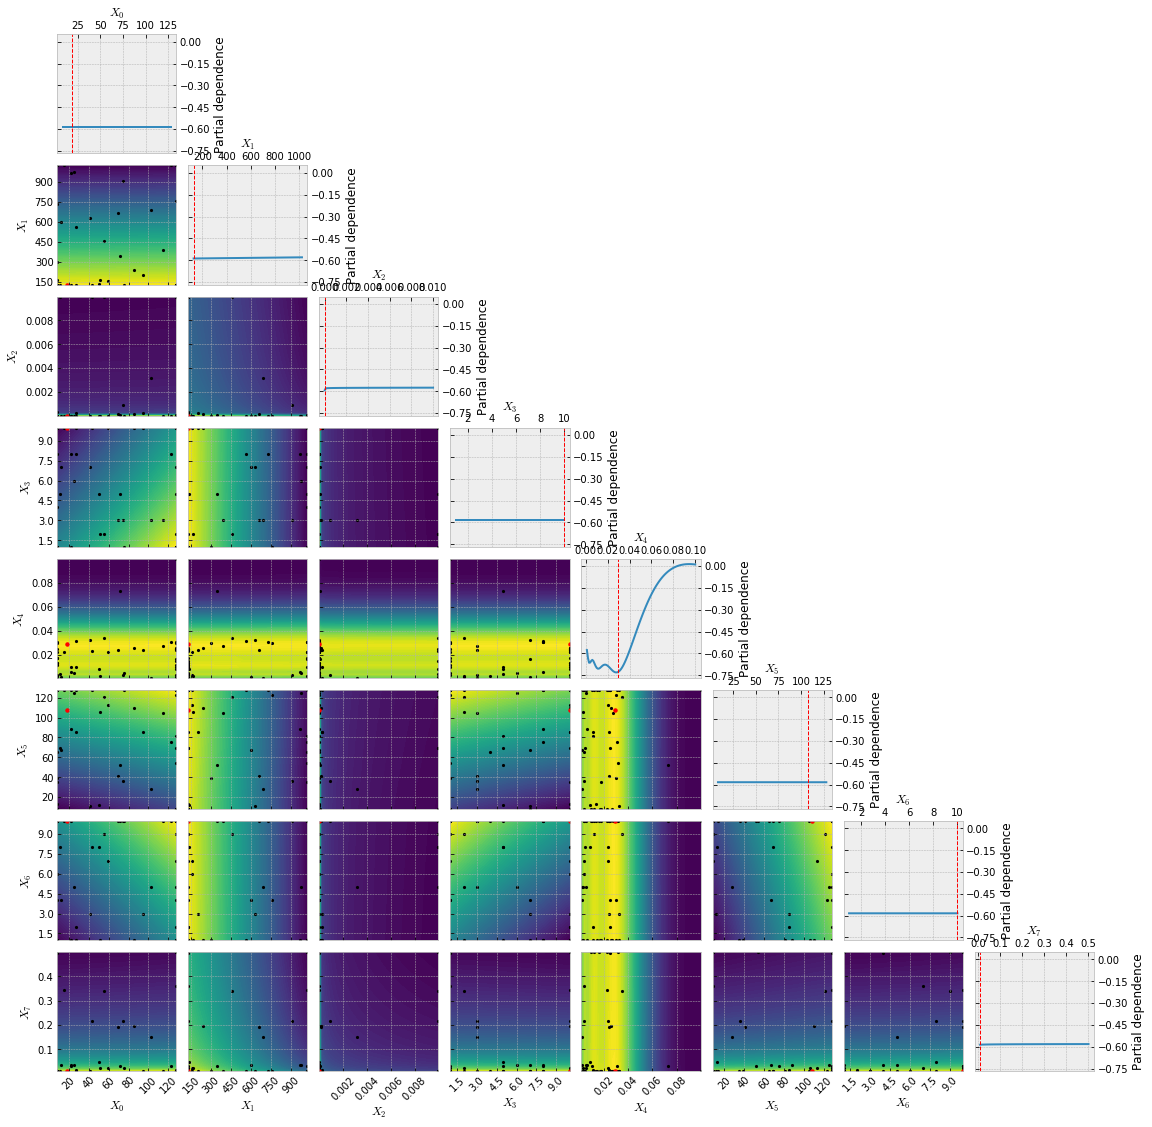

In [11]:
%matplotlib inline
from skopt.plots import plot_objective
plot_objective(result, levels=101, n_points=101);

In [13]:
opt.optimizer.Xi[np.argmin(opt.optimizer.yi)]

[18, 128, 2.6671031786945325e-09, 10, 0.029073892277448457, 108, 10, 0.01]

In [12]:
from skopt.utils import expected_minimum
expected_minimum(result)

([37.0,
  531.0,
  2.8272300482784265e-08,
  8.0,
  0.013461857810783013,
  40.0,
  10.0,
  0.045538118616911163],
 -0.66668570041656494)

In [29]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 110
n_hidden_set_layers = 3
n_hidden_joint_units = 30
n_hidden_joint_layers = 1
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=0.0030455606129349486, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=1983,
                          kernel_regularizer=l2(2.9256460783464019e-09))

2018-04-11 08:53:23,469 - FATERankingCore - INFO - Construct joint layers hidden units 30 and layers 1 
2018-04-11 08:53:23,470 - FATERankingCore - INFO - Construct output score node
2018-04-11 08:53:23,471 - FATEObjectRankingCore - INFO - args: {'metrics': None, 'batch_size': 1983, 'optimizer': <keras.optimizers.SGD object at 0x7f177fce5cc0>, 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7f177fce5c88>, 'n_hidden_joint_units': 30, 'n_hidden_joint_layers': 1}
2018-04-11 08:53:23,472 - FATEChoiceFunction - INFO - Creating set layers with set units 110 set layer 3 


In [30]:
fate.fit(X_train, Y_train, verbose=True, epochs=100)

Train on 8100 samples, validate on 900 samples
Epoch 1/100
8100/8100 [==============================] - 15s 2ms/step - loss: 0.8895 - val_loss: 0.7170
Epoch 2/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.6784 - val_loss: 0.6195
Epoch 3/100
8100/8100 [==============================] - 0s 21us/step - loss: 0.6071 - val_loss: 0.5727
Epoch 4/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.5614 - val_loss: 0.5218
Epoch 5/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.5152 - val_loss: 0.4827
Epoch 6/100
8100/8100 [==============================] - 0s 21us/step - loss: 0.4840 - val_loss: 0.4610
Epoch 7/100
8100/8100 [==============================] - 0s 21us/step - loss: 0.4665 - val_loss: 0.4469
Epoch 8/100
8100/8100 [==============================] - 0s 21us/step - loss: 0.4531 - val_loss: 0.4345
Epoch 9/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.4413 - val_loss: 0.4245
Epoch 10/100
8100

8100/8100 [==============================] - 0s 20us/step - loss: 0.3212 - val_loss: 0.3176
Epoch 79/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.3203 - val_loss: 0.3168
Epoch 80/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.3194 - val_loss: 0.3160
Epoch 81/100
8100/8100 [==============================] - 0s 22us/step - loss: 0.3185 - val_loss: 0.3153
Epoch 82/100
8100/8100 [==============================] - 0s 22us/step - loss: 0.3177 - val_loss: 0.3146
Epoch 83/100
8100/8100 [==============================] - 0s 21us/step - loss: 0.3169 - val_loss: 0.3138
Epoch 84/100
8100/8100 [==============================] - 0s 19us/step - loss: 0.3160 - val_loss: 0.3130
Epoch 85/100
8100/8100 [==============================] - 0s 20us/step - loss: 0.3151 - val_loss: 0.3122
Epoch 86/100
8100/8100 [==============================] - 0s 19us/step - loss: 0.3142 - val_loss: 0.3116
Epoch 87/100
8100/8100 [==============================] - 0s 20us/st

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [14]:
fate = opt.model

In [15]:
pred = fate.predict(X_test)
pred_scores = fate.predict_scores(X_test)

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
#auc = roc_auc_score(Y_test, pred_scores, average='samples')
auc = '-'
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home

F1: 0.7962372367501779
Precision: 0.7947603968253968
Recall: 0.8143094841269841
Subset 0/1 Loss: 0.26039999999999996
Hamming loss: 0.0484
AUC: -
MAP: nan


In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
#auc = roc_auc_score(Y_test, pred_scores, average='samples')
auc = '-'
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home

F1: 0.7643864220093632
Precision: 0.7535642857142858
Recall: 0.8088015476190475
Subset 0/1 Loss: 0.3288
Hamming loss: 0.06328
AUC: -
MAP: nan


In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, hamming_loss, zero_one_loss, recall_score, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import label_ranking_loss
f1 = f1_score(Y_test, pred, average='samples')
prec = precision_score(Y_test, pred, average='samples')
rec = recall_score(Y_test, pred, average='samples')
subsetloss = zero_one_loss(Y_test, pred)
hamming = hamming_loss(Y_test, pred)
#auc = roc_auc_score(Y_test, pred_scores, average='samples')
auc = '-'
maps = average_precision_score(Y_test, pred_scores, average='samples')
print('F1: {}\nPrecision: {}\nRecall: {}\nSubset 0/1 Loss: {}\nHamming loss: {}\nAUC: {}\nMAP: {}'.format(
    f1, prec, rec, subsetloss, hamming, auc, maps))

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home

F1: 0.5532010449294428
Precision: 0.49491480158730167
Recall: 0.7541459523809524
Subset 0/1 Loss: 0.791
Hamming loss: 0.22576
AUC: -
MAP: nan
